# Content-based recommender using Natural Language Processing (NLP)
## A guide to build a content-based recommender model based on NLP

IMDB top 250 English movies dataset is taken from data.world https://data.world/studentoflife/imdb-top-250-lists-and-5000-or-so-data-records

The attributes used for similarity comparison/calculation includes genre, plot, director and (three) main actors.

## Step 1: import Python libraries and dataset, perform EDA
Ensure that the Rapid Automatic Keyword Extraction (RAKE) library has been installed (or pip install rake_nltk). Refer to https://pypi.org/project/rake-nltk/ for more information.

In [1]:
# !pip install rake_nltk
from rake_nltk import Rake   # ensure this is installed

import nltk
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")

In [2]:
# df = pd.read_csv('https://query.data.world/s/uikepcpffyo2nhig52xxeevdialfl7')   # 250 rows × 38 columns
df = pd.read_csv('IMDB_Top250Engmovies2_OMDB_Detailed.csv')   # same data 250 rows × 38 columns
df

Unnamed: 0                     Title  Year      Rated     Released  \
0             1  The Shawshank Redemption  1994          R  14 Oct 1994   
1             2             The Godfather  1972          R  24 Mar 1972   
2             3    The Godfather: Part II  1974          R  20 Dec 1974   
3             4           The Dark Knight  2008      PG-13  18 Jul 2008   
4             5              12 Angry Men  1957   APPROVED  01 Apr 1957   
..          ...                       ...   ...        ...          ...   
245         246          The Lost Weekend  1945  NOT RATED  01 Jan 1946   
246         247             Short Term 12  2013          R  23 Aug 2013   
247         248           His Girl Friday  1940   APPROVED  18 Jan 1940   
248         249        The Straight Story  1999          G  03 Nov 1999   
249         250       Slumdog Millionaire  2008          R  25 Dec 2008   

     Runtime                   Genre                      Director  \
0    142 min            Crime, Drama                Frank Darabont   
1    175 min            Crime, Drama          Francis Ford Coppola   
2    202 min            Crime, Drama          Francis Ford Coppola   
3    152 min    Action, Crime, Drama             Christopher Nolan   
4     96 min            Crime, Drama                  Sidney Lumet   
..       ...                     ...                           ...   
245  101 min        Drama, Film-Noir                  Billy Wilder   
246   96 min                   Drama         Destin Daniel Cretton   
247   92 min  Comedy, Drama, Romance                  Howard Hawks   
248  112 min        Biography, Drama                   David Lynch   
249  120 min                   Drama  Danny Boyle, Loveleen Tandan   

                                                Writer  \
0    Stephen King (short story "Rita Hayworth and S...   
1    Mario Puzo (screenplay), Francis Ford Coppola ...   
2    Francis Ford Coppola (screenplay), Mario Puzo ...   
3    Jonathan Nolan (screenplay), Christopher Nolan...   
4    Reginald Rose (story), Reginald Rose (screenplay)   
..                                                 ...   
245  Charles R. Jackson (from the novel by), Charle...   
246                              Destin Daniel Cretton   
247  Charles Lederer (screen play), Ben Hecht (from...   
248                           John Roach, Mary Sweeney   
249   Simon Beaufoy (screenplay), Vikas Swarup (novel)   

                                                Actors  ... tomatoConsensus  \
0    Tim Robbins, Morgan Freeman, Bob Gunton, Willi...  ...             NaN   
1    Marlon Brando, Al Pacino, James Caan, Richard ...  ...             NaN   
2    Al Pacino, Robert Duvall, Diane Keaton, Robert...  ...             NaN   
3    Christian Bale, Heath Ledger, Aaron Eckhart, M...  ...             NaN   
4    Martin Balsam, John Fiedler, Lee J. Cobb, E.G....  ...             NaN   
..                                                 ...  ...             ...   
245  Ray Milland, Jane Wyman, Phillip Terry, Howard...  ...             NaN   
246  Brie Larson, John Gallagher Jr., Stephanie Bea...  ...             NaN   
247  Cary Grant, Rosalind Russell, Ralph Bellamy, G...  ...             NaN   
248  Sissy Spacek, Jane Galloway Heitz, Joseph A. C...  ...             NaN   
249  Dev Patel, Saurabh Shukla, Anil Kapoor, Raj Zu...  ...             NaN   

    tomatoUserMeter tomatoUserRating tomatoUserReviews  \
0               NaN              NaN               NaN   
1               NaN              NaN               NaN   
2               NaN              NaN               NaN   
3               NaN              NaN               NaN   
4               NaN              NaN               NaN   
..              ...              ...               ...   
245             NaN              NaN               NaN   
246             NaN              NaN               NaN   
247             NaN              NaN               NaN   
248             NaN              NaN 

In [7]:
# data overview
print('Rows x Columns : ', df.shape[0], 'x', df.shape[1])
print('Features: ', df.columns.tolist())
print('\nUnique values:')
print(df.nunique())
for col in df.columns:
    print(col, end=': ')
    print(df[col].unique())

Rows x Columns :  250 x 5
Features:  ['Title', 'Director', 'Actors', 'Plot', 'Genre']

Unique values:
Title       250
Director    155
Actors      248
Plot        250
Genre       110
dtype: int64
Title: ['The Shawshank Redemption' 'The Godfather' 'The Godfather: Part II'
 'The Dark Knight' '12 Angry Men' "Schindler's List"
 'The Lord of the Rings: The Return of the King' 'Pulp Fiction'
 'Fight Club' 'The Lord of the Rings: The Fellowship of the Ring'
 'Forrest Gump' 'Star Wars: Episode V - The Empire Strikes Back'
 'Inception' 'The Lord of the Rings: The Two Towers'
 "One Flew Over the Cuckoo's Nest" 'Goodfellas' 'The Matrix'
 'Star Wars: Episode IV - A New Hope' 'Se7en' "It's a Wonderful Life"
 'The Silence of the Lambs' 'The Usual Suspects' 'Léon: The Professional'
 'Saving Private Ryan' 'City Lights' 'Interstellar' 'American History X'
 'Modern Times' 'Casablanca' 'The Green Mile' 'Psycho'
 'Raiders of the Lost Ark' 'The Pianist' 'Rear Window' 'The Departed'
 'Whiplash' 'Terminator 2

In [8]:
# type of entries, how many missing values/null fields
df.info()
print('\nMissing values:  ', df.isnull().sum().values.sum())
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
Title       250 non-null object
Director    250 non-null object
Actors      250 non-null object
Plot        250 non-null object
Genre       250 non-null object
dtypes: object(5)
memory usage: 9.9+ KB

Missing values:   0


Title       0
Director    0
Actors      0
Plot        0
Genre       0
dtype: int64

In [9]:
# summary statistics for all numerical columns
df.describe().T

count unique                                                top freq
Title      250    250                                           Whiplash    1
Director   250    155                                   Alfred Hitchcock    9
Actors     250    248  Chris Pratt, Zoe Saldana, Dave Bautista, Vin D...    2
Plot       250    250  An insomniac office worker, looking for a way ...    1
Genre      250    110                                              Drama   19

In [6]:
# keep only these 5 useful columns, 250 rows with no NaN field
df = df[['Title','Director','Actors','Plot','Genre']]
df

Title                      Director  \
0    The Shawshank Redemption                Frank Darabont   
1               The Godfather          Francis Ford Coppola   
2      The Godfather: Part II          Francis Ford Coppola   
3             The Dark Knight             Christopher Nolan   
4                12 Angry Men                  Sidney Lumet   
..                        ...                           ...   
245          The Lost Weekend                  Billy Wilder   
246             Short Term 12         Destin Daniel Cretton   
247           His Girl Friday                  Howard Hawks   
248        The Straight Story                   David Lynch   
249       Slumdog Millionaire  Danny Boyle, Loveleen Tandan   

                                                Actors  \
0    Tim Robbins, Morgan Freeman, Bob Gunton, Willi...   
1    Marlon Brando, Al Pacino, James Caan, Richard ...   
2    Al Pacino, Robert Duvall, Diane Keaton, Robert...   
3    Christian Bale, Heath Ledger, Aaron Eckhart, M...   
4    Martin Balsam, John Fiedler, Lee J. Cobb, E.G....   
..                                                 ...   
245  Ray Milland, Jane Wyman, Phillip Terry, Howard...   
246  Brie Larson, John Gallagher Jr., Stephanie Bea...   
247  Cary Grant, Rosalind Russell, Ralph Bellamy, G...   
248  Sissy Spacek, Jane Galloway Heitz, Joseph A. C...   
249  Dev Patel, Saurabh Shukla, Anil Kapoor, Raj Zu...   

                                                  Plot                   Genre  
0    Two imprisoned men bond over a number of years...            Crime, Drama  
1    The aging patriarch of an organized crime dyna...            Crime, Drama  
2    The early life and career of Vito Corleone in ...            Crime, Drama  
3    When the menace known as the Joker emerges fro...    Action, Crime, Drama  
4    A jury holdout attempts to prevent a miscarria...            Crime, Drama  
..                                                 ...                     ...  
245  The desperate life of a chronic alcoholic is f...        Drama, Film-Noir  
246  A 20-something supervising staff member of a r...                   Drama  
247  A newspaper editor uses every trick in the boo...  Comedy, Drama, Romance  
248  An old man makes a long journey by lawn-mover ...        Biography, Drama  
249  A Mumbai teen reflects on his upbringing in th...                   Drama  

[250 rows x 5 columns]

In [10]:
df.loc[(df.Genre == 'Drama')]

Title                      Director  \
8                         Fight Club                 David Fincher   
14   One Flew Over the Cuckoo's Nest                  Milos Forman   
63               Requiem for a Dream              Darren Aronofsky   
81                     All About Eve          Joseph L. Mankiewicz   
85                 Good Will Hunting                  Gus Van Sant   
105                             Room              Lenny Abrahamson   
121                    Trainspotting                   Danny Boyle   
124                      Gran Torino                Clint Eastwood   
139                          Network                  Sidney Lumet   
170                     Paris, Texas                   Wim Wenders   
171            The Last Picture Show             Peter Bogdanovich   
189  Who's Afraid of Virginia Woolf?                  Mike Nichols   
192                         The Help                   Tate Taylor   
213         A Streetcar Named Desire                    Elia Kazan   
233                      Sling Blade            Billy Bob Thornton   
235                         Magnolia          Paul Thomas Anderson   
236                         Rain Man                Barry Levinson   
246                    Short Term 12         Destin Daniel Cretton   
249              Slumdog Millionaire  Danny Boyle, Loveleen Tandan   

                                                Actors  \
8    Edward Norton, Brad Pitt, Meat Loaf, Zach Grenier   
14   Michael Berryman, Peter Brocco, Dean R. Brooks...   
63   Ellen Burstyn, Jared Leto, Jennifer Connelly, ...   
81   Bette Davis, Anne Baxter, George Sanders, Cele...   
85   Matt Damon, Ben Affleck, Stellan Skarsgård, Jo...   
105  Brie Larson, Jacob Tremblay, Sean Bridgers, We...   
121  Ewan McGregor, Ewen Bremner, Jonny Lee Miller,...   
124  Clint Eastwood, Christopher Carley, Bee Vang, ...   
139  Faye Dunaway, William Holden, Peter Finch, Rob...   
170  Harry Dean Stanton, Sam Berry, Bernhard Wicki,...   
171  Timothy Bottoms, Jeff Bridges, Cybill Shepherd...   
189  Elizabeth Taylor, Richard Burton, George Segal...   
192  Emma Stone, Viola Davis, Bryce Dallas Howard, ...   
213  Vivien Leigh, Marlon Brando, Kim Hunter, Karl ...   
233  Billy Bob Thornton, Dwight Yoakam, J.T. Walsh,...   
235  Pat Healy, Genevieve Zweig, Mark Flanagan, Nei...   
236  Dustin Hoffman, Tom Cruise, Valeria Golino, Ge...   
246  Brie Larson, John Gallagher Jr., Stephanie Bea...   
249  Dev Patel, Saurabh Shukla, Anil Kapoor, Raj Zu...   

                                                  Plot  Genre  
8    An insomniac office worker, looking for a way ...  Drama  
14   A criminal pleads insanity after getting into ...  Drama  
63   The drug-induced utopias of four Coney Island ...  Drama  
81   An ingenue insinuates herself into the company...  Drama  
85   Will Hunting, a janitor at M.I.T., has a gift ...  Drama  
105  A young boy is raised within the confines of a...  Drama  
121  Renton, deeply immersed in the Edinburgh drug ...  Drama  
124  Disgruntled Korean War veteran Walt Kowalski s...  Drama  
139  A television network cynically exploits a dera...  Drama  
170  Travis Henderson, an aimless drifter who has b...  Drama  
171  In 1951, a group of high schoolers come of age...  Drama  
189  A bitter, aging couple, with the help of alcoh...  Drama  
192  An aspiring author during the civil rights mov...  Drama  
213  Disturbed Blanche DuBois moves in with her sis...  Drama  
233  Karl Childers, a simple man hospitalized since...  Drama  
235  An epic mosaic of interrelated characters in s...  Drama  
236  Selfish yuppie Charlie Babbitt's father left a...  Drama  
246  A 20-something supervising staff member of a r...  Drama  
249  A Mumbai teen reflects on his upbringing in th...  Drama

In [11]:
# top genres (from 110 unique genres)
df['Genre'].value_counts()

Drama                           19
Crime, Drama                    14
Drama, War                       9
Animation, Adventure, Comedy     8
Crime, Drama, Thriller           8
                                ..
Crime, Thriller                  1
Film-Noir, Mystery               1
Action, Crime, Thriller          1
Crime, Drama, Fantasy            1
Biography, Drama, Sport          1
Name: Genre, Length: 110, dtype: int64

In [12]:
# 10 popular directors (from 155 unique directors)
df['Director'].value_counts()[0:10].plot('barh', figsize=[8,5], fontsize=15, color='navy').invert_yaxis()

## Step 2: data pre-processing

Firstly the data has to be pre-processed using NLP to obtain only one column that contains all the attributes (in words) of each movie. After that, this information is converted into numbers by vectorization, where scores are assigned to each word. Subsequently cosine similarities can be calculated.

### to remove stop words, punctuation, white space, and convert all words to lower case
I used the Rake function to extract the most relevant words from whole sentences in the Plot column. In order to do this, I applied this function to each row under the Plot column and assigned the list of key words to a new column 'Key_words'.

In [13]:
# to remove punctuations from Plot
df['Plot'] = df['Plot'].str.replace('[^\w\s]','')

# # alternative way to remove punctuations, same result
# import string
# df['Plot'] = df['Plot'].str.replace('[{}]'.format(string.punctuation), '')

In [14]:
# to extract key words from Plot to a list
df['Key_words'] = ''   # initializing a new column
r = Rake()   # use Rake to discard stop words (based on english stopwords from NLTK)

for index, row in df.iterrows():
    r.extract_keywords_from_text(row['Plot'])   # to extract key words from Plot, default in lower case
    key_words_dict_scores = r.get_word_degrees()    # to get dictionary with key words and their scores
    row['Key_words'] = list(key_words_dict_scores.keys())   # to assign list of key words to new column

df

Title                      Director  \
0    The Shawshank Redemption                Frank Darabont   
1               The Godfather          Francis Ford Coppola   
2      The Godfather: Part II          Francis Ford Coppola   
3             The Dark Knight             Christopher Nolan   
4                12 Angry Men                  Sidney Lumet   
..                        ...                           ...   
245          The Lost Weekend                  Billy Wilder   
246             Short Term 12         Destin Daniel Cretton   
247           His Girl Friday                  Howard Hawks   
248        The Straight Story                   David Lynch   
249       Slumdog Millionaire  Danny Boyle, Loveleen Tandan   

                                                Actors  \
0    Tim Robbins, Morgan Freeman, Bob Gunton, Willi...   
1    Marlon Brando, Al Pacino, James Caan, Richard ...   
2    Al Pacino, Robert Duvall, Diane Keaton, Robert...   
3    Christian Bale, Heath Ledger, Aaron Eckhart, M...   
4    Martin Balsam, John Fiedler, Lee J. Cobb, E.G....   
..                                                 ...   
245  Ray Milland, Jane Wyman, Phillip Terry, Howard...   
246  Brie Larson, John Gallagher Jr., Stephanie Bea...   
247  Cary Grant, Rosalind Russell, Ralph Bellamy, G...   
248  Sissy Spacek, Jane Galloway Heitz, Joseph A. C...   
249  Dev Patel, Saurabh Shukla, Anil Kapoor, Raj Zu...   

                                                  Plot  \
0    Two imprisoned men bond over a number of years...   
1    The aging patriarch of an organized crime dyna...   
2    The early life and career of Vito Corleone in ...   
3    When the menace known as the Joker emerges fro...   
4    A jury holdout attempts to prevent a miscarria...   
..                                                 ...   
245  The desperate life of a chronic alcoholic is f...   
246  A 20something supervising staff member of a re...   
247  A newspaper editor uses every trick in the boo...   
248  An old man makes a long journey by lawnmover t...   
249  A Mumbai teen reflects on his upbringing in th...   

                      Genre                                          Key_words  
0              Crime, Drama  [two, imprisoned, men, bond, eventual, redempt...  
1              Crime, Drama  [clandestine, empire, reluctant, son, organize...  
2              Crime, Drama  [tightens, 1920s, new, york, family, crime, sy...  
3      Action, Crime, Drama  [physical, tests, dark, knight, must, accept, ...  
4              Crime, Drama  [reconsider, justice, jury, holdout, attempts,...  
..                      ...                                                ...  
245        Drama, Film-Noir  [fourday, drinking, bout, desperate, life, fol...  
246                   Drama  [coworker, longtime, boyfriend, troubled, wate...  
247  Comedy, Drama, Romance  [remarrying, ace, reporter, exwife, keep, news...  
248        Biography, Drama  [lawnmover, tractor, mend, old, man, makes, re...  
249                   Drama  [indian, version, accused, wants, slums, mumba...  

[250 rows x 6 columns]

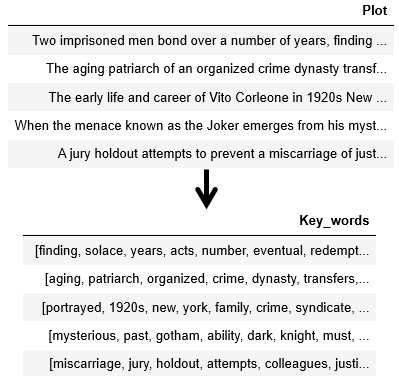

In [15]:
# to see last item in Plot
df['Plot'][249]

'A Mumbai teen reflects on his upbringing in the slums when he is accused of cheating on the Indian Version of Who Wants to be a Millionaire'

In [16]:
# to see last dictionary extracted from Plot
key_words_dict_scores

defaultdict(<function rake_nltk.rake.Rake._build_word_co_occurance_graph.<locals>.<lambda>()>,
            {'indian': 2,
             'version': 2,
             'accused': 1,
             'wants': 1,
             'slums': 1,
             'mumbai': 3,
             'teen': 3,
             'reflects': 3,
             'upbringing': 1,
             'cheating': 1,
             'millionaire': 1})

In [17]:
# to see last item in Key_words
df['Key_words'][249]

['indian',
 'version',
 'accused',
 'wants',
 'slums',
 'mumbai',
 'teen',
 'reflects',
 'upbringing',
 'cheating',
 'millionaire']

The names of actors and directors are transformed into unique identity values. This is done by merging all first and last names into one word, so that Chris Evans and Chris Hemsworth will appear different. The recommender should detect a similarity only if the person associated to different movies is exactly the same. Every word needs to be converted to lowercase to avoid duplications.

In [18]:
# to extract all genre into a list, only the first three actors into a list, and all directors into a list
df['Genre'] = df['Genre'].map(lambda x: x.split(','))
df['Actors'] = df['Actors'].map(lambda x: x.split(',')[:3])
df['Director'] = df['Director'].map(lambda x: x.split(','))

# create unique identity names by merging first & last name into one word, convert to lowercase 
for index, row in df.iterrows():
    row['Genre'] = [x.lower().replace(' ','') for x in row['Genre']]
    row['Actors'] = [x.lower().replace(' ','') for x in row['Actors']]
    row['Director'] = [x.lower().replace(' ','') for x in row['Director']]
df

Title                      Director  \
0    The Shawshank Redemption               [frankdarabont]   
1               The Godfather          [francisfordcoppola]   
2      The Godfather: Part II          [francisfordcoppola]   
3             The Dark Knight            [christophernolan]   
4                12 Angry Men                 [sidneylumet]   
..                        ...                           ...   
245          The Lost Weekend                 [billywilder]   
246             Short Term 12         [destindanielcretton]   
247           His Girl Friday                 [howardhawks]   
248        The Straight Story                  [davidlynch]   
249       Slumdog Millionaire  [dannyboyle, loveleentandan]   

                                                Actors  \
0               [timrobbins, morganfreeman, bobgunton]   
1                  [marlonbrando, alpacino, jamescaan]   
2                [alpacino, robertduvall, dianekeaton]   
3           [christianbale, heathledger, aaroneckhart]   
4               [martinbalsam, johnfiedler, leej.cobb]   
..                                                 ...   
245              [raymilland, janewyman, phillipterry]   
246   [brielarson, johngallagherjr., stephaniebeatriz]   
247         [carygrant, rosalindrussell, ralphbellamy]   
248  [sissyspacek, janegallowayheitz, josepha.carpe...   
249              [devpatel, saurabhshukla, anilkapoor]   

                                                  Plot  \
0    Two imprisoned men bond over a number of years...   
1    The aging patriarch of an organized crime dyna...   
2    The early life and career of Vito Corleone in ...   
3    When the menace known as the Joker emerges fro...   
4    A jury holdout attempts to prevent a miscarria...   
..                                                 ...   
245  The desperate life of a chronic alcoholic is f...   
246  A 20something supervising staff member of a re...   
247  A newspaper editor uses every trick in the boo...   
248  An old man makes a long journey by lawnmover t...   
249  A Mumbai teen reflects on his upbringing in th...   

                        Genre  \
0              [crime, drama]   
1              [crime, drama]   
2              [crime, drama]   
3      [action, crime, drama]   
4              [crime, drama]   
..                        ...   
245        [drama, film-noir]   
246                   [drama]   
247  [comedy, drama, romance]   
248        [biography, drama]   
249                   [drama]   

                                             Key_words  
0    [two, imprisoned, men, bond, eventual, redempt...  
1    [clandestine, empire, reluctant, son, organize...  
2    [tightens, 1920s, new, york, family, crime, sy...  
3    [physical, tests, dark, knight, must, accept, ...  
4    [reconsider, justice, jury, holdout, attempts,...  
..                                                 ...  
245  [fourday, drinking, bout, desperate, life, fol...  
246  [coworker, longtime, boyfriend, troubled, wate...  
247  [remarrying, ace, reporter, exwife, keep, news...  
248  [lawnmover, tractor, mend, old, man, makes, re...  
249  [indian, version, accused, wants, slums, mumba...  

[250 rows x 6 columns]

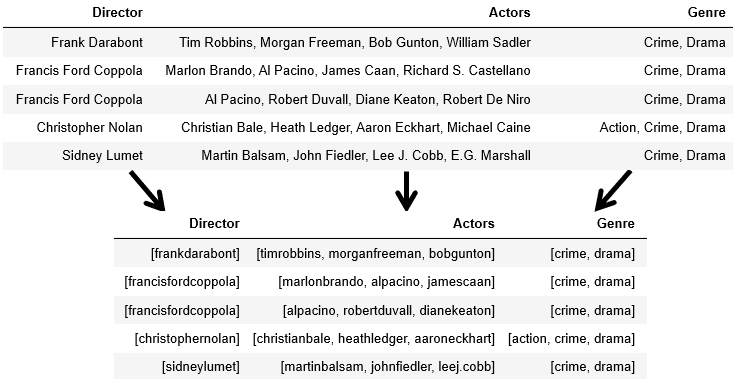

## Step 3: create word representation by combining column attributes to Bag_of_words

In [19]:
# to combine 4 lists (4 columns) of key words into 1 sentence under Bag_of_words column
df['Bag_of_words'] = ''
columns = ['Genre', 'Director', 'Actors', 'Key_words']

for index, row in df.iterrows():
    words = ''
    for col in columns:
        words += ' '.join(row[col]) + ' '
    row['Bag_of_words'] = words
    
# strip white spaces infront and behind, replace multiple whitespaces (if any)
df['Bag_of_words'] = df['Bag_of_words'].str.strip().str.replace('   ', ' ').str.replace('  ', ' ')

df = df[['Title','Bag_of_words']]
df

Title  \
0    The Shawshank Redemption   
1               The Godfather   
2      The Godfather: Part II   
3             The Dark Knight   
4                12 Angry Men   
..                        ...   
245          The Lost Weekend   
246             Short Term 12   
247           His Girl Friday   
248        The Straight Story   
249       Slumdog Millionaire   

                                          Bag_of_words  
0    crime drama frankdarabont timrobbins morganfre...  
1    crime drama francisfordcoppola marlonbrando al...  
2    crime drama francisfordcoppola alpacino robert...  
3    action crime drama christophernolan christianb...  
4    crime drama sidneylumet martinbalsam johnfiedl...  
..                                                 ...  
245  drama film-noir billywilder raymilland janewym...  
246  drama destindanielcretton brielarson johngalla...  
247  comedy drama romance howardhawks carygrant ros...  
248  biography drama davidlynch sissyspacek janegal...  
249  drama dannyboyle loveleentandan devpatel saura...  

[250 rows x 2 columns]

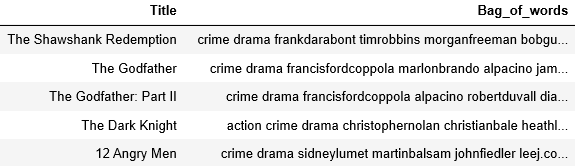

In [20]:
# an example to see what is in the Bag_of_words
df['Bag_of_words'][0]

'crime drama frankdarabont timrobbins morganfreeman bobgunton two imprisoned men bond eventual redemption years finding solace number common decency acts'

## Step 4: create vector representation for Bag_of_words and the similarity matrix

The recommender model can only read and compare a vector (matrix) with another, so we need to convert the 'Bag_of_words' into vector representation using CountVectorizer, which is a simple frequency counter for each word in the bag_of_words column. Once I have the matrix containing the count for each word, I can apply the cosine_similarity function to compare similarities between movies.

In [21]:
# to generate the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(df['Bag_of_words'])
count_matrix

<250x3003 sparse matrix of type '<class 'numpy.int64'>'
	with 5295 stored elements in Compressed Sparse Row format>

In [22]:
# to generate the cosine similarity matrix (size 250 x 250)
# rows represent all movies; columns represent all movies
# cosine similarity: similarity = cos(angle) = range from 0 (different) to 1 (similar)
# all the numbers on the diagonal are 1 because every movie is identical to itself (cosine value is 1 means exactly identical)
# matrix is also symmetrical because the similarity between A and B is the same as the similarity between B and A.
# for other values eg 0.1578947, movie x and movie y has similarity value of 0.1578947

cosine_sim = cosine_similarity(count_matrix, count_matrix)
print(cosine_sim)

[[1.         0.15789474 0.13764944 ... 0.05407381 0.05407381 0.05564149]
 [0.15789474 1.         0.36706517 ... 0.05407381 0.05407381 0.05564149]
 [0.13764944 0.36706517 1.         ... 0.04714045 0.04714045 0.04850713]
 ...
 [0.05407381 0.05407381 0.04714045 ... 1.         0.05555556 0.0571662 ]
 [0.05407381 0.05407381 0.04714045 ... 0.05555556 1.         0.0571662 ]
 [0.05564149 0.05564149 0.04850713 ... 0.0571662  0.0571662  1.        ]]


### Similarity Matrix
Next is to create a Series of movie titles, so that the series index can match the row/column index of the similarity matrix

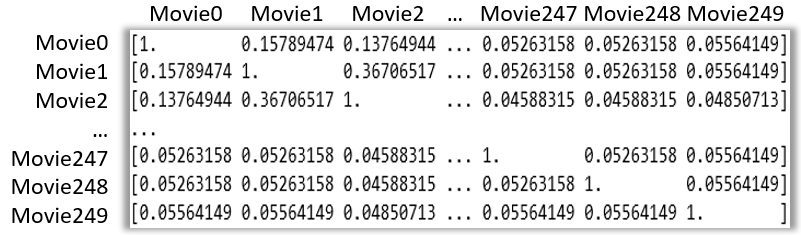

In [23]:
# to create a Series for movie titles which can be used as indices (each index is mapped to a movie title)
indices = pd.Series(df['Title'])
indices[:5]

0    The Shawshank Redemption
1               The Godfather
2      The Godfather: Part II
3             The Dark Knight
4                12 Angry Men
Name: Title, dtype: object

## Step 5: run and test the recommender model
The final step is to create a function that takes in a movie title as input, and returns the top 10 similar movies. This function will match the input movie title with the corresponding index of the Similarity Matrix, and extract the row of similarity values in descending order. The top 10 similar movies can be found by extracting the top 11 values and subsequently discarding the first index (which is the input movie itself)

In [24]:
# this function takes in a movie title as input and returns the top 10 recommended (similar) movies

def recommend(title, cosine_sim = cosine_sim):
    recommended_movies = []
    idx = indices[indices == title].index[0]   # to get the index of the movie title matching the input movie
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)   # similarity scores in descending order
    top_10_indices = list(score_series.iloc[1:11].index)   # to get the indices of top 10 most similar movies
    # [1:11] to exclude 0 (index 0 is the input movie itself)
    
    for i in top_10_indices:   # to append the titles of top 10 similar movies to the recommended_movies list
        recommended_movies.append(list(df['Title'])[i])
        
    return recommended_movies

recommend('The Dark Knight')

['The Dark Knight Rises',
 'Batman Begins',
 'The Green Mile',
 'Witness for the Prosecution',
 'Out of the Past',
 'Rush',
 'The Prestige',
 'The Godfather',
 'Reservoir Dogs',
 'V for Vendetta']

In [25]:
recommend('Fargo')

['No Country for Old Men',
 'The Departed',
 'Rope',
 'The Godfather',
 'Reservoir Dogs',
 'The Godfather: Part II',
 'On the Waterfront',
 'Goodfellas',
 'Touch of Evil',
 'The Big Lebowski']

In [26]:
recommend('The Avengers')

['Guardians of the Galaxy Vol. 2',
 'Aliens',
 'Guardians of the Galaxy',
 'The Martian',
 'Terminator 2: Judgment Day',
 'The Terminator',
 'The Thing',
 'Interstellar',
 'Spider-Man: Homecoming',
 'The Matrix']

## Conclusion
The model has recommended very similar movies. From my "domain knowledge", I can see some similarities mainly based on directors and plot. I have already watched most of these recommended movies, and am looking forward to watch those few unseen ones.